# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using Random; Random.seed!(0); 
rng = MersenneTwister(1234);

const EqSteps = 50
const NumSteps = 5000 #Monte Carlo production steps

#k = 2
#L = 2^k
const L = 16
const N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
UpTriangle = zeros(Int,N,3)
for i = 1:N
    UpTriangle[i,1] = i
    UpTriangle[i,2] = i+1    
    UpTriangle[i,3] = i+L
    #fix PBCs
    if mod(i,L) == 0
        UpTriangle[i,2] = i + 1 - L
    end
    if (i+L)> N
        UpTriangle[i,3] = i + L - N
    end
end

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
AssociatedTri = zeros(Int,N,3)
for i = 1:N
    AssociatedTri[i,1] = i
    AssociatedTri[i,2] = i-1
    AssociatedTri[i,3] = i-L
    if mod(i-1+L,L) == 0
        AssociatedTri[i,2] = i - 1 + L
    end
    if i<(L+1) 
        AssociatedTri[i,3] = i + N - L
    end
end

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += 0.5 * Spin1 * Spin2 * Spin3  #J = 1
    end
    return Energy
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    SpinCopy = copy(Spin)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    local_e_before = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  

    #flip the spin
    SpinCopy[spin_index] *= -1
    
    local_e_after = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    
    #println(spin_index," ",local_e_before," ",local_e_after)
    
    return local_e_after - local_e_before
end

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(beta,DeltaE)::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (exp(-beta*DeltaE) > rnum)
            return true
        end
    end 
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
Eexact = zeros(Float64,0)
Acceptance = zeros(Float64,0) 

To = 1.0
const gamma = 0.05

#for T = 1:-0.1:0.1  #count down
for time = 0:50
    
    print(time," ")
    T = exp(-gamma*time)
    beta = 1.0/T

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    A_rate = 0
    for step = 1:NumSteps
        Accept = 0
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
                Accept += 1
            end 
        end #i
        E_avg += Energy
        A_rate += Accept/N
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta)) 
    println(T," ",E_avg/NumSteps/N," ",E_exact-0.5," ",A_rate/NumSteps)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(Eexact,E_exact-0.5)
    push!(Acceptance,A_rate/NumSteps)

end #T


0 1.0 -0.23176171875 -0.2310585786300049 0.355378125
1 0.951229424500714 -0.2413109375 -0.2410189098634476 0.33302109375
2 0.9048374180359595 -0.2506125 -0.25122772556372186 0.31030078125
3 0.8607079764250578 -0.262053125 -0.2616658465277084 0.286765625
4 0.8187307530779818 -0.27200546875 -0.27231031459107935 0.2635328125
5 0.7788007830714049 -0.28261796875 -0.2831342122881081 0.242178125
6 0.7408182206817178 -0.29440546875 -0.29410654400704594 0.21909296875
7 0.7046880897187134 -0.3054125 -0.30519219582497953 0.19772734375
8 0.6703200460356393 -0.31522421875 -0.3163519917645896 0.17969609375
9 0.6376281516217732 -0.32733671875 -0.3275428638318262 0.1583890625
10 0.6065306597126334 -0.3373359375 -0.3387181516044302 0.140665625
11 0.5769498103804866 -0.35005390625 -0.3498280441111027 0.121609375
12 0.5488116360940264 -0.3611828125 -0.36082017210170436 0.1053890625
13 0.522045776761016 -0.373146875 -0.3716403525034072 0.08960703125
14 0.49658530379140947 -0.3832078125 -0.3822334789856840

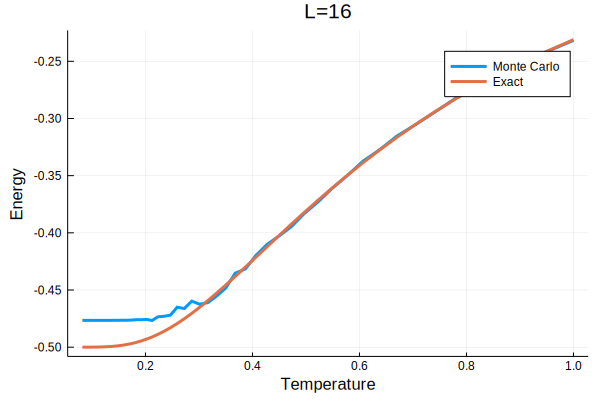

In [8]:
using Plots

plot(Tarr, [EMC, Eexact], title = "L=16", label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")

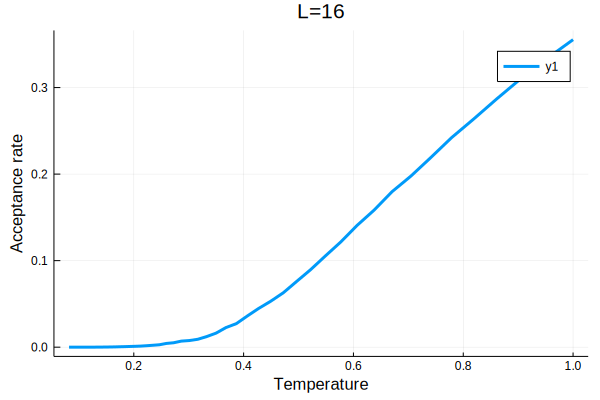

In [9]:
plot(Tarr, Acceptance, title = "L=16", lw = 3 )
xlabel!("Temperature")
ylabel!("Acceptance rate")

In [10]:
Spin

256-element Array{Int64,1}:
  1
  1
 -1
 -1
  1
 -1
 -1
 -1
  1
  1
  1
  1
  1
  ⋮
  1
 -1
 -1
 -1
 -1
  1
 -1
  1
 -1
  1
 -1
 -1